# Project Description

You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

# Technical description

- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 07-12-2020
- The date when they stopped taking up new users: 21-12-2020
- End date: 01-01-2021
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

# Description of the data

- `ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020
- `final_ab_new_users_upd_us.csv` — all users who signed up in the online store from December 7 to 21, 2020
- `final_ab_events_upd_us.csv` — all events of the new users within the period from December 7, 2020 to January 1, 2021
- `final_ab_participants_upd_us.csv` — table containing test participants

Structure of `ab_project__marketing_events_us.csv`:

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

Structure of `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

Structure of `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

Structure of `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

# Project Instruction

- Describe the goals of the study.
- Explore the data:

    - Do types need to be converted?
    - Are there any missing or duplicate values? If so, what are they like?

- Carry out exploratory data analysis:

    - Study conversion at different stages of the funnel.
    - Is the number of events per user distributed equally among the samples?
    - Are there users who are present in both samples? 
    - How is the number of events distributed among days?
    - Are there any peculiarities in the data that you have to take into account before starting the A/B test?

- Evaluate the A/B test results:

    - What can you say about the A/B test results?
    - Use a z-test to check the statistical difference between the proportions.

- Describe your conclusions regarding the EDA stage and the A/B test results.

## Data Checking and Preparing

In [1]:
# import library
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

### df_event_calendar

In [2]:
df_event_calendar = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')

In [3]:
df_event_calendar

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
# Check missing value
df_event_calendar.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [5]:
# check duplicates
df_event_calendar.duplicated().sum()

0

In [6]:
df_event_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [7]:
# converting to datetime
df_event_calendar['start_dt'] = pd.to_datetime(df_event_calendar['start_dt'])

In [8]:
# converting to datetime
df_event_calendar['finish_dt'] = pd.to_datetime(df_event_calendar['finish_dt'])

In [9]:
df_event_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


**findings:**

- no duplicates and missing values found

### df_new_users

In [10]:
df_new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')

In [11]:
df_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [12]:
df_new_users.shape

(58703, 4)

In [13]:
# check missing value
df_new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [14]:
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [15]:
# converting to datetime
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])

In [16]:
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [17]:
# check duplicates
df_new_users.duplicated().sum()

0

**findings:**

- no duplicates and missing values found

### df_events

In [18]:
df_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')

In [19]:
df_events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [20]:
df_events.shape

(423761, 4)

In [21]:
# check missing value
df_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [22]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [23]:
# converting to datetime
df_events['event_dt'] = pd.to_datetime(df_events['event_dt'])

In [24]:
# adding date only column
df_events['date'] = df_events['event_dt'].dt.date

In [25]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
 4   date        423761 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.2+ MB


In [26]:
# check duplicates
df_events.duplicated().sum()

0

In [27]:
df_events.head(10)

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99,2020-12-07
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99,2020-12-07
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99,2020-12-07
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,2020-12-07


**findings:**

- there's quite a lot of missing data in `details` column

### df_participants

In [28]:
df_participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [29]:
df_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [30]:
df_participants.shape

(14525, 3)

In [31]:
df_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [32]:
# check missing value
df_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [33]:
# check duplicates
df_participants.duplicated().sum()

0

In [34]:
df_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5467
                        B         5383
recommender_system_test A         2747
                        B          928

**findings:**

- no duplicates and missing values found

## Exploratory Data Analysis

### Study conversion at different stages of the funnel.

In [35]:
# finding how many events are there
events = len(df_events)
events

423761

In [36]:
# finding how many users are there
users = len(df_events['user_id'].unique())
users

58703

In [37]:
# finding average events per user
events_per_user = events / users
round(events_per_user, 0)

7.0

In [38]:
# for each funnel
df_events.pivot_table(index='event_name', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,182465
product_page,120862
purchase,60314
product_cart,60120


In [39]:
# for users that does every events
users_per_event = (
    df_events.pivot_table(index='event_name', values='user_id', aggfunc='nunique')
    .sort_values('user_id', ascending=False)
)

In [40]:
users_per_event

,user_id
event_name,
login,58696
product_page,38929
purchase,19568
product_cart,19284


In [41]:
# calculating proporsion
users_per_event / df_events['user_id'].nunique()

,user_id
event_name,
login,0.999881
product_page,0.663152
purchase,0.333339
product_cart,0.328501


**findings:**

- for me, it's a bit weird that the event `purchase` is higher than `product_cart`. 
- from what i know, the correct sequence of events should be `login` --> `product_page` --> `product_cart` --> `purchase`.
- it might be that, some users didn't put the product they want in the cart but goes directly into purchase. 

### Is the number of events per user distributed equally among the samples?

**findings:**

- from what we can conclude in `users_per_event`, it shows that not every events has the same number of users. in that case, it might be safe to say that the events per user is not distributed equally. 

### Are there users who are present in both samples? 

In [42]:
df_participants.query('group == "A" and group == "B"')

,user_id,group,ab_test


**findings:**

- currently, there are no users that are present in both group `A` and `B` at the same time

### How is the number of events distributed among days?

In [43]:
df_events.pivot_table(index='date', values='event_name', aggfunc='count')

,event_name
date,
2020-12-07,11385
2020-12-08,12547
2020-12-09,12122
2020-12-10,14077
2020-12-11,13864
2020-12-12,17634
2020-12-13,20985
2020-12-14,26184
2020-12-15,23469


<AxesSubplot:xlabel='date'>

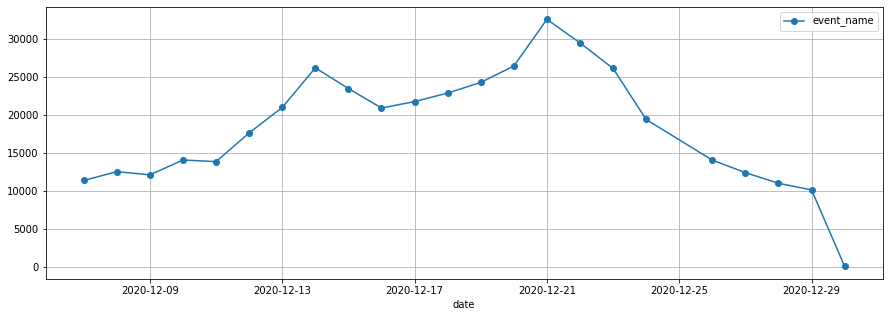

In [44]:
df_events.pivot_table(index='date', values='event_name', aggfunc='count').plot(style='o-', grid=True, figsize=(15,5))

### Are there any peculiarities in the data that you have to take into account before starting the A/B test?

- Test name: `recommender_system_test`
    - any test beside that shouldn't be inculuded
- Groups: А (control), B (new payment funnel)
- Launch date: 07-12-2020
- The date when they stopped taking up new users: 21-12-2020
- End date: 01-01-2021
    - any event outside the requirement date shouldn't be included
- Audience: 15% of the new users from the EU region
    - any event outside EU shouldn't be included
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

In [45]:
# merging data for df_new_users
df_new_users_merged = df_new_users.merge(df_participants, on='user_id', how='left')
df_new_users_merged.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN


In [46]:
# merging data for df_events
df_events_merged = df_events.merge(df_participants, on='user_id', how='left')
df_events_merged.head()

,user_id,event_dt,event_name,details,date,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,NaN,NaN


In [47]:
# query for eu only 
df_event_calendar['is_eu'] = df_event_calendar['regions'].apply(lambda x: 'EU' in x.split(', '))
df_event_calendar_eu = df_event_calendar.query('is_eu == True')

In [48]:
df_event_calendar

,name,regions,start_dt,finish_dt,is_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,True
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,True
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,True
4,4th of July Promo,N.America,2020-07-04,2020-07-11,False
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,True
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,False
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,True
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,True
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,False


In [49]:
df_event_calendar_eu

,name,regions,start_dt,finish_dt,is_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,True
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,True
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,True
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,True
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,True
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,True


In [50]:
# query for experiment time limit date
df_event_calendar_eu.query('(start_dt >= "2020-12-07" and start_dt <= "2021-01-01") or \
                           (finish_dt >= "2020-12-07" and finish_dt <= "2021-01-01")')

,name,regions,start_dt,finish_dt,is_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True


In [51]:
# query for recommender_system_test
df_participants = df_participants.query('ab_test == "recommender_system_test"')
df_new_users_merged = df_new_users_merged.query('ab_test == "recommender_system_test"')
df_events_merged = df_events_merged.query('ab_test == "recommender_system_test"')

In [52]:
df_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


In [53]:
df_new_users_merged

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
19,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
23,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
39,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
40,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test
...,...,...,...,...,...,...
59538,3CA972F86411CF13,2020-12-20,EU,PC,A,recommender_system_test
59542,A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test
59551,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
59567,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test


In [54]:
df_events_merged

,user_id,event_dt,event_name,details,date,group,ab_test
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,recommender_system_test
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A,recommender_system_test
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B,recommender_system_test
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,A,recommender_system_test
75,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B,recommender_system_test
...,...,...,...,...,...,...,...
429396,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-29,A,recommender_system_test
429415,96BDD55846D1F7F6,2020-12-29 16:53:42,login,NaN,2020-12-29,A,recommender_system_test
429425,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,2020-12-29,A,recommender_system_test
429439,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN,2020-12-30,B,recommender_system_test


In [55]:
# calculating participants proporsion based on group
participants_report = df_participants.groupby('group').agg({'user_id': 'nunique'})
participants_report['% users'] = (participants_report['user_id'] / participants_report['user_id'].sum()).round(2)
participants_report.sort_values(by = 'user_id', ascending = False)

,user_id,% users
group,,
A,2747,0.75
B,928,0.25


**findings:**

- the distribution between the 2 samples of group `A` and `B` is not equal, this might leads to inaccurate test results.

## A/B Testing

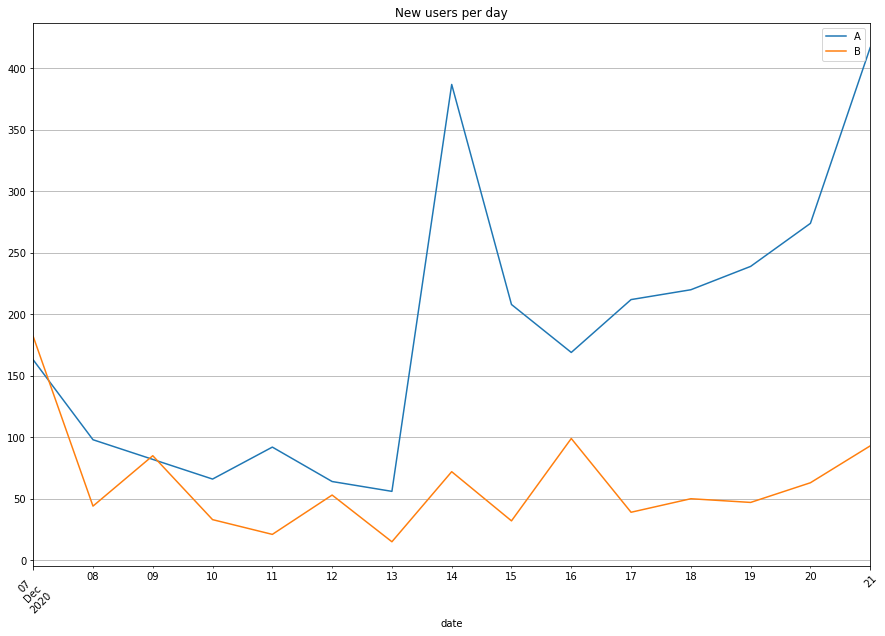

In [56]:
pd.pivot_table(df_new_users_merged, 
               index = 'first_date', 
               columns = 'group', 
               values = 'user_id', 
               aggfunc = 'count').plot(grid = True, figsize = (15, 10))
plt.title('New users per day')
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.legend()

**findings:**

- this graph visualize the difference in number between samples from group `A` and `B`.
- it shows that the samples collected in `A` is higher than `B`.

### finding difference between conversion % to use product page

In [57]:
df_events_product_page_agg = (df_events_merged.query('event_name == "product_page"').groupby('user_id')
                              .agg({'event_dt': 'count'}))
df_events_product_page_agg

,event_dt
user_id,
001064FEAAB631A1,3
0010A1C096941592,4
003DF44D7589BBD4,5
006E3E4E232CE760,3
0082295A41A867B5,5
...,...
FF5A1CD38F5DD996,5
FF5B24BCE4387F86,3
FF8CF7057415EB29,1


In [58]:
report = df_participants.merge(df_events_product_page_agg, on = 'user_id', how = 'left')
report['is_buyer'] = (report['event_dt'] > 0).astype(int)
report = (report.groupby('group').agg({'user_id': 'count', 'is_buyer': 'sum'})
                                 .rename(columns = {'user_id': 'participants', 'is_buyer': 'product page users'}))
report['conversion'] = (report['product page users'] / report['participants']).round(2)
report

,participants,product page users,conversion
group,,,
A,2747,1780,0.65
B,928,523,0.56


In [59]:
# finding difference between conversion % to use product page
alpha = 0.05
count = list(report['product page users'].values)
nobs = list(report['participants'].values)

pvalue = proportions_ztest(count, nobs)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('The null hypothesis is not rejected: there is no difference between groups A and B in the % of users who use the product page')
else:
    print('The null hypothesis is rejected: there is a difference between groups A and B in the % of users who use the product page.')

p-value: 4.310980554712425e-06
The null hypothesis is rejected: there is a difference between groups A and B in the % of users who use the product page.


###  finding difference between conversion % to use product cart

In [60]:
df_events_product_cart_agg = (df_events_merged.query('event_name == "product_cart"').groupby('user_id')
                              .agg({'event_dt': 'count'}))
df_events_product_cart_agg

,event_dt
user_id,
003DF44D7589BBD4,5
0082295A41A867B5,5
00E68F103C66C1F7,3
00EFA157F7B6E1C4,3
01553AABC481F26C,4
...,...
FEC0BCA6C323872F,3
FF2174A1AA0EAD20,1
FF44696E39039D29,2


In [61]:
report = df_participants.merge(df_events_product_cart_agg, on = 'user_id', how = 'left')
report['is_buyer'] = (report['event_dt'] > 0).astype(int)
report = (report.groupby('group').agg({'user_id': 'count', 'is_buyer': 'sum'})
                                 .rename(columns = {'user_id': 'participants', 'is_buyer': 'product cart users'}))
report['conversion'] = (report['product cart users'] / report['participants']).round(2)
report

,participants,product cart users,conversion
group,,,
A,2747,824,0.30
B,928,255,0.27


In [62]:
# finding difference between conversion % to use product cart
count = list(report['product cart users'].values)
nobs = list(report['participants'].values)

pvalue = proportions_ztest(count, nobs)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('The null hypothesis is not rejected: there is no difference between groups A and B in the % of users who use the product cart')
else:
    print('The null hypothesis is rejected: there is a difference between groups A and B in the % of users who use the product cart.')

p-value: 0.14534814557238196
The null hypothesis is not rejected: there is no difference between groups A and B in the % of users who use the product cart


###  finding difference between conversion % to purchase

In [63]:
df_events_purchase_agg = df_events_merged.query('event_name == "purchase"').groupby('user_id').agg({'details': 'count'})
df_events_purchase_agg

,details
user_id,
0010A1C096941592,4
005E096DBD379BCF,2
0082295A41A867B5,5
00C1F5175586DFCF,3
01157AAD4401952B,2
...,...
FEC8EB9C054264BC,4
FEF5165C8A0DC6BD,3
FF2174A1AA0EAD20,1


In [64]:
report = df_participants.merge(df_events_purchase_agg, on = 'user_id', how = 'left')
report['is_buyer'] = (report['details'] > 0).astype(int)
report = (report.groupby('group').agg({'user_id': 'count', 'is_buyer': 'sum'})
                                 .rename(columns = {'user_id': 'participants', 'is_buyer': 'buyers'}))
report['conversion'] = (report['buyers'] / report['participants']).round(2)
report

,participants,buyers,conversion
group,,,
A,2747,872,0.32
B,928,256,0.28


In [65]:
# finding difference between conversion % to purchase
count = list(report['buyers'].values)
nobs = list(report['participants'].values)

pvalue = proportions_ztest(count, nobs)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('The null hypothesis is not rejected: there is no difference in conversion % to purchase between groups A and B.')
else:
    print('The null hypothesis is rejected: there is a difference in conversion % to purchase between groups A and B.')

p-value: 0.017592402663314678
The null hypothesis is rejected: there is a difference in conversion % to purchase between groups A and B.


## Conclusion

**findings in EDA:**
- The only event that match the criteria is the `Christmas&New Year Promo` which was available in EU and in accordance with the limit of the date 
- Test participants were unevenly distributed between the test groups in which group `A` is higher than group `B`.

**findings in the proportions z-test:**
- results:
    - there **is** a difference between groups A and B in the % of users who use the `product_page`.
    - there is **no** difference between groups A and B in the % of users who use the `product_cart`.
    - there **is** a difference in conversion % to `purchase` between groups A and B.
- although, it should be noted that the conversion in the test group was much lower than in the control group and the uneven distribution of group `A` and `B` should make us suspicious about the results.

**Conclusion:**
- It is recommended to run another test to get correct results.